In [1]:
# Core
import os
import cv2
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & ML
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Deep Learning (Feature Extractor)
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

# XGBoost
from xgboost import XGBClassifier

# Explainability
import shap

# Warning
import warnings
warnings.filterwarnings("ignore")


In [2]:
import kagglehub

path = kagglehub.dataset_download("nizorogbezuode/rice-leaf-images")
print("Dataset path:", path)

images_root = os.path.join(path, "rice_images")


100%|██████████| 17.7M/17.7M [00:00<00:00, 80.8MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/nizorogbezuode/rice-leaf-images/versions/1


In [3]:
IMG_SIZE = 224

X_img = []
y = []

class_labels = [
    d for d in os.listdir(images_root)
    if os.path.isdir(os.path.join(images_root, d))
]

for label in class_labels:
    folder = os.path.join(images_root, label)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X_img.append(img)
        y.append(label)

X_img = np.array(X_img)
y = np.array(y)

print("Image shape:", X_img.shape)
print("Total samples:", len(y))


Image shape: (3355, 224, 224, 3)
Total samples: 3355


In [4]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

for i, cls in enumerate(le.classes_):
    print(cls, "=", i)


_BrownSpot = 0
_Healthy = 1
_Hispa = 2
_LeafBlast = 3


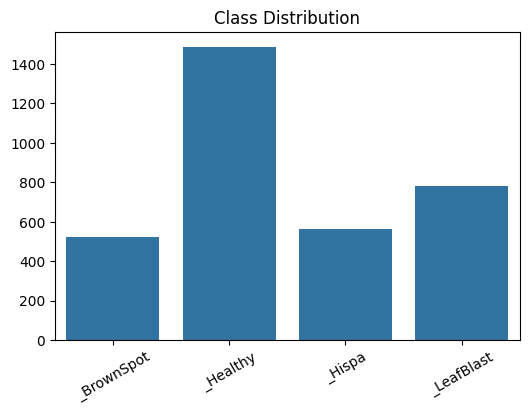

In [5]:
unique, counts = np.unique(y_encoded, return_counts=True)

plt.figure(figsize=(6,4))
sns.barplot(x=le.classes_, y=counts)
plt.title("Class Distribution")
plt.xticks(rotation=30)
plt.show()


In [6]:
X_img = preprocess_input(X_img.astype("float32"))


In [7]:
base_model = DenseNet201(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(224, 224, 3)
)

X_features = base_model.predict(X_img, batch_size=32, verbose=1)

print("Feature shape:", X_features.shape)


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 72s 397ms/step
Feature shape: (3355, 1920)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_features,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

baseline_model.fit(X_train_scaled, y_train)
y_pred_base = baseline_model.predict(X_test_scaled)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred_base))
print(classification_report(
    y_test, y_pred_base,
    target_names=le.classes_,
    zero_division=0
))


Baseline Accuracy: 0.7049180327868853
              precision    recall  f1-score   support

  _BrownSpot       0.73      0.74      0.74       104
    _Healthy       0.78      0.78      0.78       298
      _Hispa       0.50      0.51      0.51       113
  _LeafBlast       0.70      0.68      0.69       156

    accuracy                           0.70       671
   macro avg       0.68      0.68      0.68       671
weighted avg       0.71      0.70      0.71       671



In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(
    y_test,
    y_pred_rf,
    target_names=le.classes_,
    zero_division=0
))


Random Forest Accuracy: 0.6721311475409836
              precision    recall  f1-score   support

  _BrownSpot       0.84      0.70      0.76       104
    _Healthy       0.62      0.97      0.76       298
      _Hispa       0.60      0.11      0.18       113
  _LeafBlast       0.80      0.49      0.61       156

    accuracy                           0.67       671
   macro avg       0.71      0.57      0.58       671
weighted avg       0.69      0.67      0.63       671



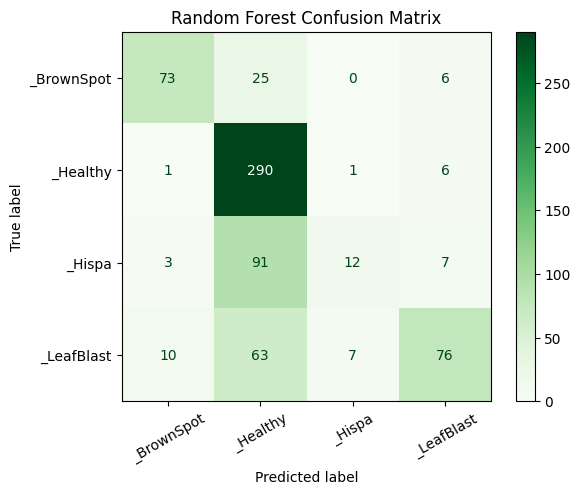

In [12]:

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(cm_rf, display_labels=le.classes_)
disp_rf.plot(cmap="Greens", xticks_rotation=30)
plt.title("Random Forest Confusion Matrix")
plt.show()


In [13]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(
    y_test,
    y_pred_xgb,
    target_names=le.classes_,
    zero_division=0
))


XGBoost Accuracy: 0.7466467958271237
              precision    recall  f1-score   support

  _BrownSpot       0.87      0.78      0.82       104
    _Healthy       0.72      0.94      0.81       298
      _Hispa       0.68      0.34      0.45       113
  _LeafBlast       0.78      0.65      0.71       156

    accuracy                           0.75       671
   macro avg       0.76      0.68      0.70       671
weighted avg       0.75      0.75      0.73       671



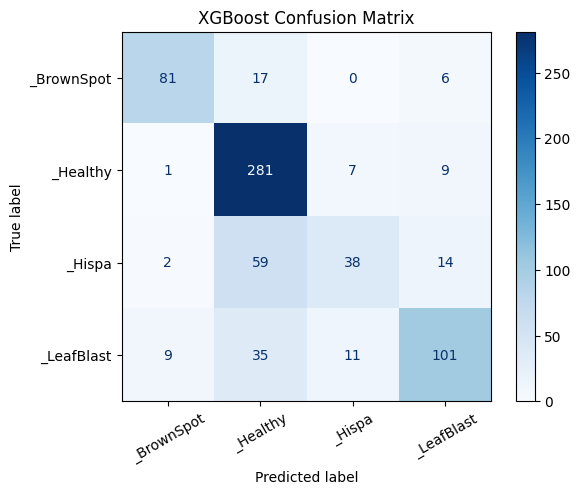

In [14]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(cm_xgb, display_labels=le.classes_)
disp_xgb.plot(cmap="Blues", xticks_rotation=30)
plt.title("XGBoost Confusion Matrix")
plt.show()


In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, classification_report
from xgboost import XGBClassifier
import numpy as np

# Parameter space: hanya 2 learning_rate
learning_rates = [0.05, 0.1]

# 5-fold Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_score = 0
best_params = {}

for lr in learning_rates:
    print(f"\nTesting learning_rate={lr}")
    fold_scores = []

    for fold_counter, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=lr,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="multi:softprob",
            eval_metric="mlogloss",
            random_state=42,
            n_jobs=-1,
            tree_method="gpu_hist",      # pakai GPU
            predictor="gpu_predictor"
        )

        model.fit(X_tr, y_tr)
        y_val_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_val_pred, average="macro")
        fold_scores.append(f1)

        print(f"  Fold {fold_counter} F1-macro: {f1:.4f}")

    mean_f1 = np.mean(fold_scores)
    print(f"Mean F1-macro for learning_rate={lr}: {mean_f1:.4f}")

    if mean_f1 > best_score:
        best_score = mean_f1
        best_params = {"learning_rate": lr}

# Print best hyperparameter
print("\n===== Best Hyperparameter =====")
print(best_params)
print("Best CV F1-macro:", best_score)

# Train final model dengan best learning_rate
best_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=best_params["learning_rate"],
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
    tree_method="gpu_hist",      # pakai GPU
    predictor="gpu_predictor"
)

best_xgb.fit(X_train, y_train)
y_pred_best = best_xgb.predict(X_test)

print("\nTuned XGBoost Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(
    y_test,
    y_pred_best,
    target_names=le.classes_,
    zero_division=0
))



Testing learning_rate=0.05
  Fold 1 F1-macro: 0.6821
  Fold 2 F1-macro: 0.6774
  Fold 3 F1-macro: 0.7066
  Fold 4 F1-macro: 0.6531
  Fold 5 F1-macro: 0.6984
Mean F1-macro for learning_rate=0.05: 0.6835

Testing learning_rate=0.1
  Fold 1 F1-macro: 0.6839
  Fold 2 F1-macro: 0.6921
  Fold 3 F1-macro: 0.7047
  Fold 4 F1-macro: 0.6594
  Fold 5 F1-macro: 0.6985
Mean F1-macro for learning_rate=0.1: 0.6877

===== Best Hyperparameter =====
{'learning_rate': 0.1}
Best CV F1-macro: 0.6877321965489216

Tuned XGBoost Accuracy: 0.7466467958271237
              precision    recall  f1-score   support

  _BrownSpot       0.87      0.78      0.82       104
    _Healthy       0.72      0.94      0.81       298
      _Hispa       0.68      0.34      0.45       113
  _LeafBlast       0.78      0.65      0.71       156

    accuracy                           0.75       671
   macro avg       0.76      0.68      0.70       671
weighted avg       0.75      0.75      0.73       671



<Figure size 800x600 with 0 Axes>

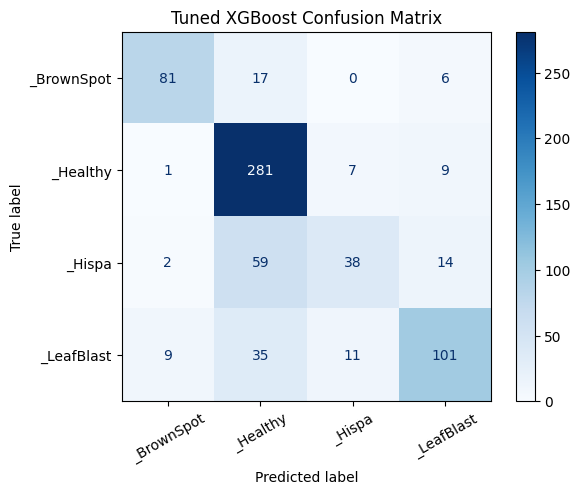

In [32]:

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(8,6))
disp.plot(cmap="Blues", xticks_rotation=30)
plt.title("Tuned XGBoost Confusion Matrix")
plt.show()

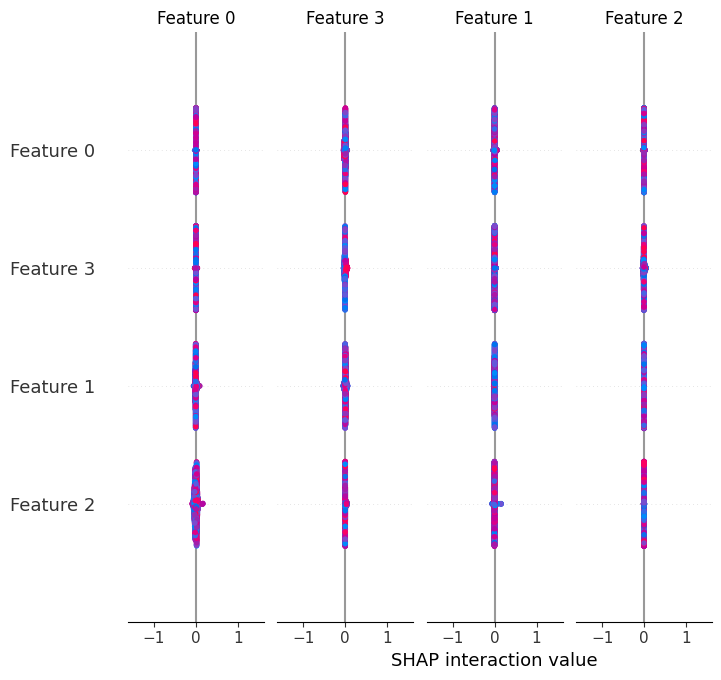

In [40]:

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_features)

shap.summary_plot(shap_values, X_features, show=True)


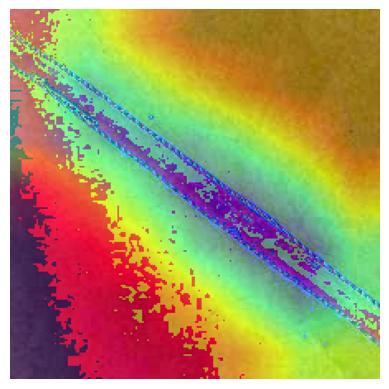

In [41]:


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



img = X_img[0][np.newaxis, ...]
heatmap = make_gradcam_heatmap(img, base_model, last_conv_layer_name='conv5_block32_concat')


img_orig = (img[0]*255).astype(np.uint8)
heatmap = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_color, 0.4, 0)

plt.imshow(superimposed_img)
plt.axis('off')
plt.show()



In [42]:
import joblib

# Simpan best_xgb hasil hyperparameter tuning
joblib.dump(best_xgb, "xgb_best_model.pkl")
print("Best XGBoost model saved!")


Best XGBoost model saved!
